In [0]:
### Author : Venkat Mohanram (iknevece@gmail.com)
### Updates by : Narayan Parthasarathy

# **IMPORT MODULES**

In [0]:
# Setting seed for reproducable results
from numpy.random import seed
seed(1)

In [0]:
### IMPORT NECESSARY MODULES

import string
import random
import os
from os import listdir
import shutil
import pandas as pd
from numpy import array, argmax
import pickle
from pickle import load, dump

from keras.utils import to_categorical
from keras.utils import plot_model

from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from keras import regularizers

from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vgg16_ppi

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_ppi

from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as xception_ppi

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

Using TensorFlow backend.


In [0]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


# **Defining Functions**

In [0]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r', encoding='latin-1')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [0]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		identifier = identifier.replace('"','')
		dataset.append(identifier)
	while("" in dataset): dataset.remove("")
	return set(dataset)

In [0]:
# extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split('|')
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# remove filename from image id
		image_id = image_id.split('.')[0]
		image_id = image_id.replace('"','')
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

In [0]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

In [0]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		image_id = image_id.replace('"','')
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

In [0]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

In [0]:
# save descriptions to file, one per line
def save_desc_tt(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			desc = desc.replace('"','')
			lines.append(key + '|' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

In [0]:
# save image filenames to file, one per line
def save_image_filename(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		key = key.replace('"','')
		lines.append(key.strip() + '.jpg')
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

In [0]:
# load photo features
def load_photo_features(filename, dataset):
	# load all features
  all_features = load(open(filename, 'rb'))
  features = dict()
  try:
    # filter features
    features = {k: all_features[k] for k in dataset}
  #except KeyError as ke:
  #  pass
  finally:
    return features

In [0]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

In [0]:
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

In [0]:
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [0]:
# calculate the length of the description with the most words
def maxm_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

In [0]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
	X1, X2, y = list(), list(), list()
	# walk through each description for the image
	for desc in desc_list:
		# encode the sequence
		seq = tokenizer.texts_to_sequences([desc])[0]
		# split one sequence into multiple X,y pairs
		for i in range(1, len(seq)):
			# split into input and output pair
			in_seq, out_seq = seq[:i], seq[i]
			# pad input sequence
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			# encode output sequence
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			# store
			X1.append(photo)
			X2.append(in_seq)
			y.append(out_seq)
	return array(X1), array(X2), array(y)

In [0]:
# define the captioning model
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = add([fe2,se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	# compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
	model.summary()
	plot_model(model, to_file='model.png', show_shapes=True)
	return model

In [0]:
# define the captioning model
def base_model(vocab_size, max_length, model_name, option, units):
  global model_png
  # feature extractor model
  if model_name == 'VGG16':
    inputs1 = Input(shape=(4096,))
  elif model_name == 'INCEPTIONV3' or model_name == 'XCEPTION' :
    inputs1 = Input(shape=(2048,))
  fe1 = Dropout(0.5)(inputs1)
  fe2 = Dense(units, activation='relu')(fe1)
  # sequence model
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, units, embeddings_initializer='glorot_uniform', mask_zero=True)(inputs2) #embeddings_regularizer = regularizers.l2(0.01),
  se2 = Dropout(0.5)(se1)
  #if model_name == 'VGG16':
  if option == 1:
    se3 = LSTM(units)(se2) #LSTM(units, return_sequences=True)(se2)
    #se4 = Dropout(0.5)(se3)
    #se5 = LSTM(units)(se3)
  #elif model_name == 'INCEPTIONV3' or model_name == 'XCEPTION' :
  elif option == 2:
    se3 = GRU(units)(se2) #GRU(units,return_sequences=True)(se2)
    #se4 = Dropout(0.5)(se3)
    #se5 = GRU(units)(se3)
  else:
    print("Invalid model selection")
    exit()
  # decoder model
  decoder1 = add([fe2,se3])
  decoder2 = Dense(units, activation='relu')(decoder1)   
    
  outputs = Dense(vocab_size, activation='softmax')(decoder2)
  # tie it together [image, seq] [word]
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  # compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam')
  # summarize model
  model.summary()
  plot_model(model, to_file=model_png, show_shapes=True)
  return model

In [0]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
	# loop for ever over images
	while 1:
		for key, desc_list in descriptions.items():
			# retrieve the photo feature
			photo = photos[key][0]
			in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
			yield [[in_img, in_seq], out_word]

In [0]:
def split_train_test_file(filename, trainfile, testfile):
  fp = open(filename, 'r')
  num_lines = sum(1 for line in open(filename))
  half = round(num_lines / 2)
  out1 = open(trainfile, 'w')
  out2 = open(testfile, 'w')
  for i,line in enumerate(fp):
    if i <= half:
      out1 = open(trainfile, 'a')
      #out1.write(line.split('.')[0] + '\n')
      out1.write(line)
      out1.close()
    else:
      out2 = open(testfile, 'a')
      #out2.write(line.split('.')[0] + '\n')
      out2.write(line)
      out2.close()

In [0]:
def split_train_test(filename, trainfile, testfile, size):
  doc = load_doc(filename)
  data = list()
  for line in doc.split('\n'):
    data.append(line)
  random.shuffle(data)
  df_o = pd.DataFrame(data)
  df = df_o.copy()
  train = df.sample(frac=size, random_state=1)
  test = df.drop(train.index)
  train.to_csv(trainfile, index=False, header=False)
  test.to_csv(testfile, index=False, header=False)
  #return train, test
  

In [0]:
# train dataset
def train_dataset(trainfile, desc_file, features_pkl):
  # load training dataset
  train = load_set(trainfile)
  
  # descriptions
  train_descriptions = load_clean_descriptions(desc_file, train)
  
  # photo features
  train_features = load_photo_features(features_pkl, train)
  
  # prepare tokenizer
  tokenizer = create_tokenizer(train_descriptions)
  vocab_size = len(tokenizer.word_index) + 1
  
  # determine the maximum sequence length
  max_length = maxm_length(train_descriptions)
  
  # save the descriptions file
  save_desc_tt(train_descriptions, train_desc_file)
  
  return train, train_descriptions, train_features, tokenizer, vocab_size, max_length

In [0]:
# test dataset
def test_dataset(testfile, desc_file, features_pkl):
  # load test set
  test = load_set(testfile)

  # descriptions
  test_descriptions = load_clean_descriptions(desc_file, test)
  
  # photo features
  test_features = load_photo_features(features_pkl, test)
  
  # save descriptions file
  save_desc_tt(test_descriptions, test_desc_file)

  return test, test_descriptions, test_features

In [0]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

In [0]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

In [0]:
# extract features from photo
def extract_features(filename, model_name):
  # load the model
  if model_name == 'VGG16':
    model = VGG16()
  elif model_name == 'INCEPTIONV3' :
    model = InceptionV3()
  elif model_name == 'XCEPTION' :
    model = Xception()
	# re-structure the model
  model.layers.pop()
  model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
  # load the photo
  if model_name == 'VGG16':
    image = load_img(filename, target_size=(224, 224))
  elif model_name == 'INCEPTIONV3' or model_name == 'XCEPTION' :
    image = load_img(filename, target_size=(299, 299))
  # convert the image pixels to a numpy array
  image = img_to_array(image)
  # reshape data for the model
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  # prepare the image for the respective model
  if model_name == 'VGG16':
    image = vgg16_ppi(image)
  elif model_name == 'INCEPTIONV3' :
    image = inception_ppi(image)
  elif model_name == 'XCEPTION' :
    image = xception_ppi(image)
  # get features
  feature = model.predict(image, verbose=0)
  return feature

In [0]:
def get_description(image, model_name, model, tokenizer, max_length):
  # load and prepare the photograph
  photo = extract_features(image, model_name)
  #print(photo)
  # generate description
  desc = generate_desc(model, tokenizer, photo, max_length)
  desc = desc.replace('startseq','')
  desc = desc.replace('endseq','')
  img=mpimg.imread(image)
  imgplot = plt.imshow(img)
  return plt.show() , "Image Caption : " + desc


In [0]:
# Generate description for test images
#def get_desc_test(image, model_name, model, tokenizer, max_length):
def get_desc_test(image, model, tokenizer, max_length, test_features):
  # load and prepare the photograph
  #photo = extract_features(image, model_name)
  photo = test_features[image]
  # generate description
  desc = generate_desc(model, tokenizer, photo, max_length)
  desc = desc.replace('startseq','')
  desc = desc.replace('endseq','')
  desc = desc.replace('"','')
  return desc


# **Model build starts here**

In [0]:
# Setting Paths for the files
project_path      = '/content/drive/My Drive/CAPSTONE/'
project           = 'Venkat/'
tmp_path          = project_path + 'tmp/' + project
examples_path     = project_path + 'Examples/'
features_path     = project_path + 'Features/'
output_path       = project_path + 'Output/' + project
models_path       = project_path + 'Models/' + project
images_path       = project_path + 'Datasets/Master/Master/'
final_model_path  = models_path + 'Final/'

#########################################################
"""
keyfile             = 'key_caption_1k.txt'
desc_file           = output_path + 'descriptions_1k.txt'
images_file         = output_path + 'images_file_1k.txt'
trainfile           = output_path + 'Train/' + 'trainImages_1k.txt'
train_desc_file     = output_path + 'Train/' + 'train_descriptions_1k.csv'
testfile            = output_path + 'Test/' + 'testImages_1k.txt'
test_desc_file      = output_path + 'Test/' + 'test_descriptions_1k.csv'
test_desc_preds     = output_path + 'Test/' + 'test_descriptions_preds_1k.csv'
tokenizer_pkl       = output_path + 'tokenizer_1k.pkl'
features_vgg16_pkl  = features_path + 'features_vgg16_1k.pkl'
features_incp_pkl   = features_path + 'features_incep_1k.pkl'
features_xcep_pkl   = features_path + 'features_xcep_1k.pkl'
"""
#########################################################
keyfile             = 'key_caption_master_final.txt'
desc_file           = output_path + 'descriptions_master_2.txt'
images_file         = output_path + 'images_file_master_2.txt'
trainfile           = output_path + 'Train/' + 'trainImages_master_2.txt'
train_desc_file     = output_path + 'Train/' + 'train_descriptions_master_2.csv'
testfile            = output_path + 'Test/' + 'testImages_master_2.txt'
test_desc_file      = output_path + 'Test/' + 'test_descriptions_master_2.csv'
tokenizer_pkl       = output_path + 'tokenizer_master_2.pkl'
features_vgg16_pkl  = features_path + 'features_vgg16_master_1.pkl'
features_incp_pkl   = features_path + 'features_incep_master_1.pkl'
features_xcep_pkl   = features_path + 'features_xcep_master_1.pkl'

In [0]:
# Define which model to be built and fit
# Uncomment the model name that would be used and comment all other lines
model_name      = 'VGG16'
#model_name     = 'INCEPTIONV3'
#model_name     = 'XCEPTION'

# Parameters for model fit
option      = 1     #option 1 for 2 LSTM layers and option 2 for 2 GRU layers
units       = 256   #Number of units for each layer
size        = 0.7   #Train test split size
num_epochs  = 4     #Number of total epochs to run

#model_h5       = 'model_'+ model_name + '_1k.h5'
model_h5        = 'model_'+ model_name + '_' + str(option) + '_master_1.h5'
model_png       = 'model_'+ model_name + '_' + str(option) + '_1.png'
final_model     = final_model_path + model_h5
final_model_png = final_model_path + model_png
tmp_epoch       = tmp_path + model_name + '_epoch.txt'

if option == 1:
  test_desc_preds = output_path + 'Test/' + model_name + '_1LSTM' + str(units) + '_4E_2.csv'
elif options == 2:
  test_desc_preds = output_path + 'Test/' + model_name + '_1GRU' + str(units) + '_4E_2.csv'
else:
  test_desc_preds = output_path + 'Test/' + 'test_desc_predictions_1.csv'


In [0]:
os.chdir(project_path)

# load descriptions
doc = load_doc(keyfile)

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

# clean descriptions
clean_descriptions(descriptions)

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

# save to file
save_descriptions(descriptions, desc_file)
save_image_filename(descriptions, images_file)

Loaded: 24281 
Vocabulary Size: 15322


In [0]:
# Creating seperate train and test files from original file
if os.path.isfile(tmp_epoch):
  e = open(tmp_epoch,'r')
  epoch = e.read()
  e.close()
  epochs, prev_model, tt_split = epoch.split(' ')
  epochs = int(epochs)
  if tt_split == 'True':
    split_train_test(images_file, trainfile, testfile, size)
  else:
    print("Continuing with previous epoch count, model and existing train and test files.")
  if epochs == 0 : 
    epochs = num_epochs
    split_train_test(images_file, trainfile, testfile, size)
    prev_model = 'none'
    print("Previous epoch cycle is complete. Resetting the epochs to default and creating new train test")
else:
  epochs = num_epochs
  split_train_test(images_file, trainfile, testfile, size)
  prev_model = 'none'
  print("Using the default epochs and creating new train test files..")

Using the default epochs and creating new train test files..


In [0]:
if model_name == 'VGG16':
  train, train_descriptions, train_features, tokenizer,  vocab_size, max_length = train_dataset(trainfile, desc_file, features_vgg16_pkl)
  test, test_descriptions, test_features = test_dataset(testfile, desc_file, features_vgg16_pkl)
elif model_name == 'INCEPTIONV3':
  train, train_descriptions, train_features, tokenizer, vocab_size, max_length = train_dataset(trainfile, desc_file, features_incp_pkl)
  test, test_descriptions, test_features = test_dataset(testfile, desc_file, features_incp_pkl)
elif model_name == 'XCEPTION':
  train, train_descriptions, train_features, tokenizer, vocab_size, max_length = train_dataset(trainfile, desc_file, features_xcep_pkl)
  test, test_descriptions, test_features = test_dataset(testfile, desc_file, features_xcep_pkl)

In [0]:
# Verifying the train dataset
print('Train Dataset: %d' % len(train))
print('Train Descriptions: %d' % len(train_descriptions))
print('Train Photos: %d' % len(train_features))
print('Vocabulary Size: %d' % vocab_size)
print('Description Length: %d' % max_length)

Train Dataset: 16997
Train Descriptions: 16997
Train Photos: 16997
Vocabulary Size: 13452
Description Length: 70


In [0]:
# Verifying test dataset
print('Test Dataset: %d' % len(test))
print('Test Descriptions: %d' % len(test_descriptions))
print('Test Photos: %d' % len(test_features))

Test Dataset: 7284
Test Descriptions: 7284
Test Photos: 7284


In [0]:
# Checking if all train data is available in description file
for i in train:
  if i in train_descriptions.keys():
    pass
  else:
    print(i + " is not in desc")

In [0]:
# fit model
os.chdir(models_path)

# define the model
model = base_model(vocab_size, max_length, model_name, option, units)

# train the model, run epochs manually and save after each epoch
if os.path.isfile(prev_model) : 
  print("Loading weights from previous model : ", prev_model)
  model = load_model(prev_model)
steps = len(train_descriptions)
print("Total Epochs : ", epochs)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 70, 256)      3443712     input_2[0][0]                    
___________________________________________________________________________

In [0]:
model.layers

In [0]:
model.layers[2].trainable = False

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 70, 256)      3443712     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_1[0][0]                    
____________________________________________________________________________________________

In [0]:
number_pics_per_bath = 5
steps = len(train_descriptions)//number_pics_per_bath

In [0]:
# test the data generator
generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
inputs, outputs = next(generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

(17, 4096)
(17, 70)
(17, 13452)


In [0]:
# Fit model with multiple epochs ## 1
for i in range(epochs):
  print("******* Running epoch : ", i+1 , " ******* ")
  # create the data generator
  generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
  # fit for one epoch
  #model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1, use_multiprocessing=True, shuffle=True, workers=32, max_queue_size=100)
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1, use_multiprocessing=True, workers=8, max_queue_size=10)
  # save model
  model.save('model_' + model_name + str(i) + '_3.h5')
  saved_model = 'model_' + model_name + str(i) + '_3.h5'
  f = open(tmp_epoch,'w')
  if i == (epochs-1): 
    f.write(str(epochs - (i+1)) + ' ' + saved_model + ' True')
  else:
    f.write(str(epochs - (i+1)) + ' ' + saved_model + ' False')
  f.close()
 

******* Running epoch :  1  ******* 
Epoch 1/1

/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'








3399/3399 [==============================] - 423s 125ms/step - loss: 6.7600

******* Running epoch :  2  ******* 
Epoch 1/1
3399/3399 [==============================] - 414s 122ms/step - loss: 5.3024

******* Running epoch :  3  ******* 
Epoch 1/1
3399/3399 [==============================] - 407s 120ms/step - loss: 5.1073

******* Running epoch :  4  ******* 
Epoch 1/1
3399/3399 [==============================] - 404s 119ms/step - loss: 4.9262



In [0]:
# Fit model with multiple epochs ## 2
for i in range(epochs):
  print("******* Running epoch : ", i+1 , " ******* ")
  # create the data generator
  generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
  # fit for one epoch
  #model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1, use_multiprocessing=True, shuffle=True, workers=32, max_queue_size=100)
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1, use_multiprocessing=True, workers=8, max_queue_size=10)
  # save model
  model.save('model_' + model_name + str(i) + '_3.h5')
  saved_model = 'model_' + model_name + str(i) + '_3.h5'
  f = open(tmp_epoch,'w')
  if i == (epochs-1): 
    f.write(str(epochs - (i+1)) + ' ' + saved_model + ' True')
  else:
    f.write(str(epochs - (i+1)) + ' ' + saved_model + ' False')
  f.close()
 

******* Running epoch :  1  ******* 
Epoch 1/1


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


3399/3399 [==============================] - 410s 121ms/step - loss: 4.5978
******* Running epoch :  1  ******* 
Epoch 1/1
******* Running epoch :  2  ******* 
Epoch 1/1
3399/3399 [==============================] - 413s 122ms/step - loss: 4.4393
 2  ******* 
Epoch 1/1
******* Running epoch :  3  ******* 
Epoch 1/1
3399/3399 [==============================] - 403s 119ms/step - loss: 4.3700

******* Running epoch :  4  ******* 
Epoch 1/1
3399/3399 [==============================] - 404s 119ms/step - loss: 4.1829
Epoch 1/1

In [0]:
# Fit model with multiple epochs ## 3
for i in range(epochs):
  print("******* Running epoch : ", i+1 , " ******* ")
  # create the data generator
  generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
  # fit for one epoch
  #model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1, use_multiprocessing=True, shuffle=True, workers=32, max_queue_size=100)
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1, use_multiprocessing=True, workers=8, max_queue_size=10)
  # save model
  model.save('model_' + model_name + str(i) + '_3.h5')
  saved_model = 'model_' + model_name + str(i) + '_3.h5'
  f = open(tmp_epoch,'w')
  if i == (epochs-1): 
    f.write(str(epochs - (i+1)) + ' ' + saved_model + ' True')
  else:
    f.write(str(epochs - (i+1)) + ' ' + saved_model + ' False')
  f.close()
 

******* Running epoch :  1  ******* 
Epoch 1/1


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


3399/3399 [==============================] - 412s 121ms/step - loss: 3.9986
******* Running epoch :  2  ******* 
Epoch 1/1
3399/3399 [==============================] - 414s 122ms/step - loss: 3.8559
 2  ******* 
Epoch 1/1
******* Running epoch :  3  ******* 
Epoch 1/1
3399/3399 [==============================] - 406s 119ms/step - loss: 3.7375
******* Running epoch :  4  ******* 
Epoch 1/1
3399/3399 [==============================] - 405s 119ms/step - loss: 3.6352



In [0]:
# Fit model with multiple epochs ## 4
for i in range(epochs):
  print("******* Running epoch : ", i+1 , " ******* ")
  # create the data generator
  generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
  # fit for one epoch
  #model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1, use_multiprocessing=True, shuffle=True, workers=32, max_queue_size=100)
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1, use_multiprocessing=True, workers=8, max_queue_size=10)
  # save model
  model.save('model_' + model_name + str(i) + '_3.h5')
  saved_model = 'model_' + model_name + str(i) + '_3.h5'
  f = open(tmp_epoch,'w')
  if i == (epochs-1): 
    f.write(str(epochs - (i+1)) + ' ' + saved_model + ' True')
  else:
    f.write(str(epochs - (i+1)) + ' ' + saved_model + ' False')
  f.close()
 

******* Running epoch :  1  ******* 
Epoch 1/1


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


3399/3399 [==============================] - 409s 120ms/step - loss: 3.5536
 1  ******* 
Epoch 1/1
******* Running epoch :  2  ******* 
Epoch 1/1
3399/3399 [==============================] - 418s 123ms/step - loss: 3.4427

******* Running epoch :  3  ******* 
Epoch 1/1
3399/3399 [==============================] - 405s 119ms/step - loss: 3.2913
Epoch 1/1
******* Running epoch :  4  ******* 
Epoch 1/1
3399/3399 [==============================] - 407s 120ms/step - loss: 3.2486


In [0]:
# Fit model with multiple epochs ## 5
for i in range(epochs):
  print("******* Running epoch : ", i+1 , " ******* ")
  # create the data generator
  generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
  # fit for one epoch
  #model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1, use_multiprocessing=True, shuffle=True, workers=32, max_queue_size=100)
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1, use_multiprocessing=True, workers=8, max_queue_size=10)
  # save model
  model.save('model_' + model_name + str(i) + '_3.h5')
  saved_model = 'model_' + model_name + str(i) + '_3.h5'
  f = open(tmp_epoch,'w')
  if i == (epochs-1): 
    f.write(str(epochs - (i+1)) + ' ' + saved_model + ' True')
  else:
    f.write(str(epochs - (i+1)) + ' ' + saved_model + ' False')
  f.close()
 

******* Running epoch :  1  ******* 
Epoch 1/1


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


3399/3399 [==============================] - 406s 119ms/step - loss: 3.0879
 1  ******* 
Epoch 1/1
******* Running epoch :  2  ******* 
Epoch 1/1
3399/3399 [==============================] - 422s 124ms/step - loss: 3.0371

******* Running epoch :  3  ******* 
Epoch 1/1
3399/3399 [==============================] - 412s 121ms/step - loss: 2.8123

******* Running epoch :  4  ******* 
Epoch 1/1
3399/3399 [==============================] - 407s 120ms/step - loss: 2.8745
Epoch 1/1


In [0]:
# Deleting unnecessary model files
if os.path.isdir(models_path):
  if os.path.isfile(saved_model):
    print("Final model to be retained : ", saved_model)
    shutil.move(saved_model, final_model)
  else:
    print("Seems the model {} is not saved. Using existing model {}".format(saved_model, final_model))
  if os.path.isfile(model_png):
    print("New model PNG is available at ", final_model_png)
    shutil.move(model_png, final_model_png)
  else:
    print("Using existing model PNG available at ", final_model_png)
  for modelfile in listdir(models_path):
    if os.path.isfile(modelfile) and not modelfile.startswith(saved_model):
      print("Deleting : ", modelfile)
      #os.remove(modelfile)
    else:
      pass
os.chdir(project_path)

In [0]:
# prepare train sequences
#X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)

# prepare test sequences
#X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features, vocab_size)

In [0]:
# prepare tokenizer
#tokenizer = create_tokenizer(train_descriptions)

# save the tokenizer
dump(tokenizer, open(tokenizer_pkl, 'wb'))

# load the tokenizer
tokenizer = load(open(tokenizer_pkl, 'rb'))

# pre-define the max sequence length (from training)
max_length = max_length

In [0]:
# load the model
#model = load_model(final_model)
os.chdir(models_path)
model = load_model('model_VGG163_3.h5')

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 70, 256)      3443712     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_1[0][0]                    
____________________________________________________________________________________________


553467904/553467096 [==============================] - 34s 0us/step


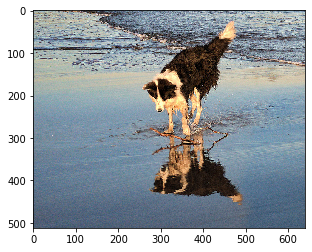

Image Caption :  animal with medium coat 


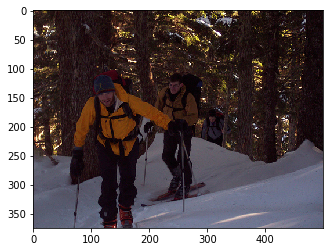

Image Caption :  animal with medium coat 


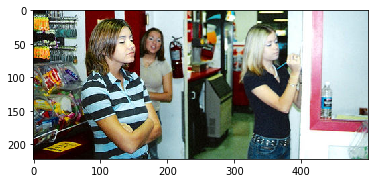

Image Caption :  animal with medium coat 


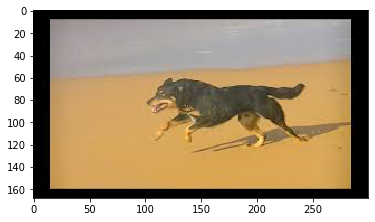

Image Caption :  animal with medium coat 


In [0]:
# Evaluating with example files
os.chdir(examples_path)
if os.path.isdir(examples_path):
  for examplefile in listdir(examples_path):
    img, desc = get_description(examplefile, model_name, model, tokenizer, max_length)
    print(desc)

In [0]:
# Evaluating with test images
lines = list()
for testimg in tqdm(test):
  desc = get_desc_test(testimg, model, tokenizer, max_length, test_features)
  lines.append(testimg + '.jpg |' + desc)
  #print(testimg + '.jpg |' + desc)

# Saving the descriptions to file
data = '\n'.join(lines)
file = open(test_desc_preds, 'w')
file.write(data)
file.close()

# **END of MODEL**